In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
dat_train = pd.read_csv('train.csv')
dat_test = pd.read_csv('test.csv')

print(dat_train.describe())
print(dat_train.info())

                 id           Age  Driving_License   Region_Code  \
count  1.150480e+07  1.150480e+07     1.150480e+07  1.150480e+07   
mean   5.752398e+06  3.838356e+01     9.980220e-01  2.641869e+01   
std    3.321149e+06  1.499346e+01     4.443120e-02  1.299159e+01   
min    0.000000e+00  2.000000e+01     0.000000e+00  0.000000e+00   
25%    2.876199e+06  2.400000e+01     1.000000e+00  1.500000e+01   
50%    5.752398e+06  3.600000e+01     1.000000e+00  2.800000e+01   
75%    8.628598e+06  4.900000e+01     1.000000e+00  3.500000e+01   
max    1.150480e+07  8.500000e+01     1.000000e+00  5.200000e+01   

       Previously_Insured  Annual_Premium  Policy_Sales_Channel       Vintage  \
count        1.150480e+07    1.150480e+07          1.150480e+07  1.150480e+07   
mean         4.629966e-01    3.046137e+04          1.124254e+02  1.638977e+02   
std          4.986289e-01    1.645475e+04          5.403571e+01  7.997953e+01   
min          0.000000e+00    2.630000e+03          1.000000e+00

In [4]:
dat_train['Vehicle_Age'].replace({'1-2 Year' : 1 , '> 2 Years' : 2, '< 1 Year' : 0}, inplace = True)
dat_train['Vehicle_Damage'].replace({ 'Yes' : 1 , 'No' : 0}, inplace = True)
dat_train['Gender'].replace({ 'Male' : 1, 'Female' : 0 } , inplace = True)

dat_test['Vehicle_Age'].replace({'1-2 Year' : 1 , '> 2 Years' : 2, '< 1 Year' : 0}, inplace = True)
dat_test['Vehicle_Damage'].replace({ 'Yes' : 1 , 'No' : 0}, inplace = True)
dat_test['Gender'].replace({ 'Male' : 1, 'Female' : 0 } , inplace = True)

In [5]:
X = dat_train.drop(columns=['id', 'Response'])
y = dat_train['Response']

X_train, X_test, y_train, y_test = train_test_split(X,y , test_size = 0.2, random_state = 42, stratify = y)

In [6]:
#xgb = XGBClassifier(objective='binary:logistic' , n_jobs = 6, scale_pos_weight= 7.13, device="cuda")
xgb = XGBClassifier(objective='binary:logistic', scale_pos_weight= 7.13, 
                           device="cuda" , colsample_bytree = 0.6 , max_depth = 8, 
                           min_child_weight = 3, eta = 0.189999, subsample = 0.9)
xgb.fit(X_train, y_train)
pred = xgb.predict(X_test)
print(roc_auc_score(y_test, pred))
#0.812630216395244
#plt.plot(fpr, tpr)


c:\Users\yingz\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:12:52] WARNING: D:\bld\xgboost-split_1713397764293\work\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[0 1 0 ... 1 0 0]
0.8129814510702533


## Fine tuning the XGB

In [15]:
from sklearn.model_selection import RandomizedSearchCV

In [17]:
param_grid = {
    #'max_depth': np.arange(4,9,1),
    #'eta': np.arange(0.01 , 0.2, 0.02),
    #'min_child_weight':range(1,6,2),
    'gamma':[i/10.0 for i in range(0,5)],
    'subsample':[i/10.0 for i in range(6,10)],
    #'colsample_bytree':[i/10.0 for i in range(6,10)],
}

fine_tuned = XGBClassifier(objective='binary:logistic', scale_pos_weight= 7.13, 
                           device="cuda" , colsample_bytree = 0.6 , max_depth = 8, 
                           min_child_weight = 3, eta = 0.189999, subsample = 0.9)

grid_acc = RandomizedSearchCV(fine_tuned, param_grid, n_iter = 200, cv = 5, scoring = 'roc_auc', verbose=1, n_jobs = 6)
grid_acc.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device='cuda',
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_ra...
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=200, n_jobs=6,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8,
                                                             0.9],
                                        'eta': array([0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19]),
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'max_depth': array([4, 5, 6, 7, 8]),
                                        'min_child_weight': range(1, 6, 2),
                                        'subsample': [0.6, 0.7, 0.8, 0.9]},
                   scoring='roc_auc', verbose=1)

In [18]:
#print(grid_acc.best_estimator_.get_params())
print(grid_acc.best_score_)
#{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.6, 'device': 'cuda', 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0.0, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 8, 'max_leaves': None, 'min_child_weight': 3, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': 7.13, 'subsample': 0.9, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'eta': 0.18999999999999997}


{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.6, 'device': 'cuda', 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0.0, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 8, 'max_leaves': None, 'min_child_weight': 3, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': 7.13, 'subsample': 0.9, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'eta': 0.18999999999999997}
0.8783942934167639


Response
0    10089739
1     1415059
Name: count, dtype: int64


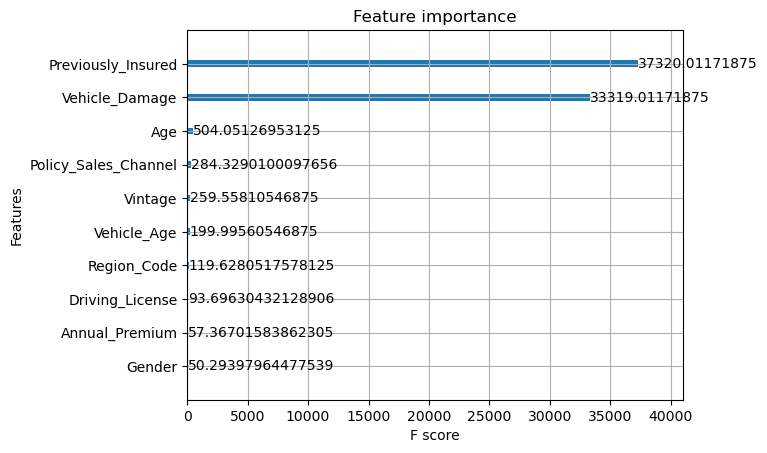

In [7]:
test = pd.DataFrame({'res': pred})
print(y.value_counts())
plot_importance(xgb , importance_type = 'gain')
plt.show()


Working on Log Regression